PREDICTING WITH PARTIAL LEAST SQUARES

---




### 1. Google Colab runtime setup [Optional]

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Clone and install spectrai package 
!git clone https://github.com/franckalbinet/spectrai.git 
!pip install /content/spectrai 

Cloning into 'spectrai'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 216 (delta 47), reused 84 (delta 25), pack-reused 99
Receiving objects: 100% (216/216), 76.51 MiB | 12.58 MiB/s, done.
Resolving deltas: 100% (53/53), done.
Processing ./spectrai
     |████████████████████████████████| 20.0MB 1.3MB/s 
     |████████████████████████████████| 10.1MB 58.4MB/s 
     |████████████████████████████████| 6.7MB 20.7MB/s 
     |████████████████████████████████| 25.2MB 130kB/s 
     |████████████████████████████████| 225kB 52.5MB/s 
     |████████████████████████████████| 86.3MB 38kB/s 
     |████████████████████████████████| 112kB 51.3MB/s 
     |████████████████████████████████| 675kB 42.6MB/s 
     |████████████████████████████████| 102kB 15.6MB/s 
     |████████████████████████████████| 71kB 10.9MB/s 
     |████████████████████████████████| 450kB 48.6MB/s 
     |██████████████████████

In [3]:
# Prepare /root folder content
!cp -r /content/drive/My\ Drive/Colab\ Notebooks/data/data_spectrai /root

In [4]:
# Create configuration file
!mkdir /root/.spectrai_config & cp /content/spectrai/config.toml /root/.spectrai_config

### 2. Import packages

In [26]:
from spectrai.datasets.kssl import (get_tax_orders_lookup_tbl, get_analytes, load_data)
from spectrai.vis.spectra import plot_spectra
from sklearn.metrics import mean_squared_error, r2_score

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

from tqdm import tqdm

from scipy.signal import savgol_filter

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 3. Load KSSL dataset

In [6]:
# Loading Potassium, NH4OAc
X, X_names, y, y_names, instances_id = load_data([725])

In [7]:
print('X shape: ', X.shape)
print('X approx. memory size: {} MB'.format(X.nbytes // 10**6))
print('y approx. memory size: {} MB'.format(y.nbytes // 10**6))
print('Wavenumbers: ', X_names)
print('Target variable: ', y_names)

X shape:  (50714, 1764)
X approx. memory size: 357 MB
y approx. memory size: 1 MB
Wavenumbers:  [3999 3997 3995 ...  603  601  599]
Target variable:  ['lay_depth_to_top' 'order_id' 'calc_value']


### 4. Data preparation and preprocessing

In [ ]:
# Display taxonomic orders
get_tax_orders_lookup_tbl()

{'alfisols': 0,
 'andisols': 7,
 'aridisols': 11,
 'entisols': 3,
 'gelisols': 12,
 'histosols': 8,
 'inceptisols': 2,
 'mollisols': 1,
 nan: 5,
 'oxisols': 9,
 'spodosols': 4,
 'ultisols': 6,
 'vertisols': 10}

In [ ]:
# Keeping data with analyte concentration > 0 only and for 'inceptisols' taxonomic order only.
TAX_ORDER_ID = 2

idx_y_valid = y[:, -1] > 0
idx_order = y[:,1] == TAX_ORDER_ID
idx = idx_y_valid & idx_order

X_subset = X[idx,:]
y_subset = y[idx,:]

### 5. Fit  and fine-tune Random Forest model 

In [ ]:
# Creating train, valid, test sets
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset[:, -1], test_size=0.30, random_state=42)

print('X train shape: ', X_train.shape)
print('X test shape: ', X_test.shape)
print('y train shape: ', y_train.shape)
print('y test shape: ', y_test.shape)

X train shape:  (2860, 1764)
X test shape:  (1226, 1764)
y train shape:  (2860,)
y test shape:  (1226,)


In [ ]:
# Set grid of hyper-parameters values to explore
param_grid = {'n_estimators': range(2, 130, 30),
              'max_depth': range(4, 6),
              'max_leaf_nodes': range(5, 20, 5)}

In [ ]:
# Setup and fit the pipeline
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring='r2', return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': range(4, 6),
     

In [ ]:
# What is the "best" combination of hyper-parameters
grid_search.best_params_

{'max_depth': 5, 'max_leaf_nodes': 15, 'n_estimators': 62}

In [ ]:
# What is the "best" score
grid_search.best_score_

0.4185448992654145

In [ ]:
print('R2 on traint set with best estimator: ', grid_search.best_estimator_.score(X_train, y_train))
print('R2 on test set with best estimator: ', grid_search.best_estimator_.score(X_test, y_test))

R2 on traint set with best estimator:  0.6215015015363958
R2 on test set with best estimator:  0.39933953003983635


### 6. XGBoost

In [8]:
## Keeping data with analyte concentration > 0 only and for 'inceptisols' taxonomic order only.
#TAX_ORDER_ID = 2

idx_y_valid = y[:, -1] > 0
#idx_order = y[:,1] == TAX_ORDER_ID
#idx = idx_y_valid & idx_order
idx = idx_y_valid

X_subset = X[idx,:]
y_subset = y[idx,:]

In [11]:
# First take first derivative
X_subset = savgol_filter(X_subset, 11, 1, 1)
X_subset = StandardScaler().fit_transform(X_subset)
#X_subset = PCA(n_components=50).fit_transform(X_subset)

In [12]:
# Classical train, test split
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.20, random_state=42)

print('X train shape: ', X_train.shape)
print('X test shape: ', X_test.shape)
print('y train shape: ', y_train.shape)
print('y test shape: ', y_test.shape)

X train shape:  (38908, 1764)
X test shape:  (9728, 1764)
y train shape:  (38908, 3)
y test shape:  (9728, 3)


In [34]:
%%time
xgb_reg = xgb.XGBRegressor(n_estimators=5000, tree_method='gpu_hist')
xgb_reg.fit(X_train, y_train[:, -1])

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[15:07:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 1min 43s, sys: 1min 3s, total: 2min 47s
Wall time: 2min 47s


In [35]:
xgb_reg.score(X_train, y_train[:, -1])

0.9845373903003359

In [36]:
xgb_reg.score(X_test, y_test[:, -1])

0.7551791479081893

In [32]:
def rpd(y, y_hat):
    sd = np.std(y, ddof=1)
    sep =  np.sqrt(mean_squared_error(y, y_hat))
    return sd / sep

In [37]:
rpd(y_test[:, -1], xgb_reg.predict(X_test))

2.0211480197734937

In [24]:
def plot_along_wn(X, X_names, y_label='Absorbance', title='Weights', figsize=(18, 4)):
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=figsize)
        ax.set_xlim(np.max(X_names), np.min(X_names))
        plt.xlabel('Wavenumber')
        plt.ylabel(y_label)
        plt.title(title)
        _ = ax.plot(X_names, X)


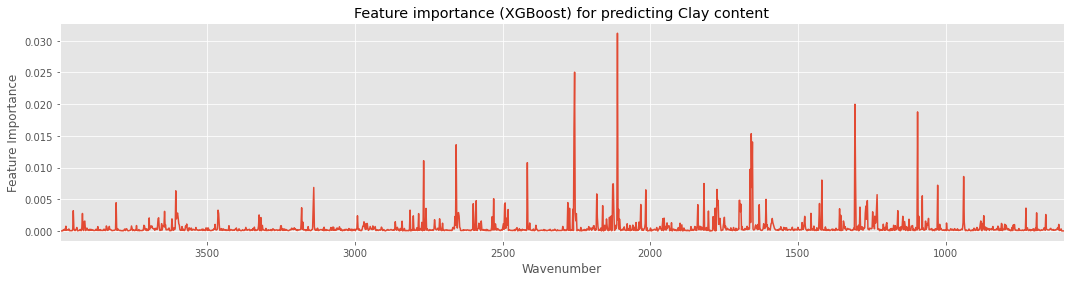

In [38]:
plot_along_wn(xgb_reg.feature_importances_, X_names, y_label='Feature Importance', title='Feature importance (XGBoost) for predicting Clay content', figsize=(18, 4))